In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from time import time

In [2]:
TType = torch.float32

def Gravity(Masses):
    N = Masses.shape[0]
    
    def f(state):
        Dim = state.shape[2]
        # state: (p-v, body, dim)
        
        X = state[0]
        V = state[1]
        
        A = torch.zeros((N, Dim), dtype=TType)
        E = 0.0
                
        for i_body in range(N):
            A[i_body][:] = 0.0
            E += Masses[i_body] * (V[i_body]**2).sum() / 2
            
            for j_body in range(N):
                if j_body == i_body:
                    continue
                    
                direction = X[j_body] - X[i_body]
                distance = (direction**2).sum().sqrt()
                E -= Masses[i_body] * Masses[j_body] / distance / 2
                A[i_body] += Masses[j_body] * direction / distance**3
                
        return torch.stack([V, A]), E
    
    def dyn(state):
        return f(state)[0]
    
    def energy(state):
        return f(state)[1]
    
    return {'dyn' : dyn, 'energy' : energy}

In [45]:
class EulerSolver:
    def __init__(self, dyn, h=0.1):
        self.dyn = dyn
        self.h = h
        
    def step(self, state, h=None):
        if h is None:
            h = self.h

        delta = h*self.dyn(state)
        new_state = state + delta
        return new_state      

class RungeKutte:
    def __init__(self, dyn, h=0.1):
        self.dyn = dyn
        self.h = h
        
    def step(self, state, h=None):
        if h is None:
            h = self.h

        k1 = self.dyn(state)
        k2 = self.dyn(state + h * 0.5 * k1)
        k3 = self.dyn(state + h * 0.5 * k2)
        k4 = self.dyn(state + h * k3)
        
        delta = h*(k1 + 2*k2 + 2*k3 + k4) / 6
        new_state = state + delta
        return new_state        

class NNSolver(nn.Module):
    def __init__(self, dyn, h=0.1):
        super().__init__()
        self.dyn = dyn
        self.h = h
        self.xs = nn.Parameter(torch.rand(3, dtype=TType))
        self.ws = nn.Parameter(torch.rand(4, dtype=TType))
        
    def step(self, state, h=None):
        if h is None:
            h = self.h

        k0 = self.dyn(state)
        k1 = self.dyn(state + h * self.xs[0] * k0)
        k2 = self.dyn(state + h * self.xs[1] * k1)
        k3 = self.dyn(state + h * self.xs[2] * k2)
        
        delta = h * (self.ws[0] * k0 + self.ws[1] * k1 + self.ws[2] * k2 + self.ws[3] * k3)
        new_state = state + delta
        return new_state   

In [25]:
def run_dynamics(state0, solvers, steps, h=None, detach=False):
    state_h = {}
    for k in solvers:
        states = [state0]
        state_h[k] = states
        solver = solvers[k]
        for i in range(steps):
            s = solver.step(state=states[-1], h=h)
            if detach:
                s = s.detach()
            
            states.append(s)
            
    return state_h

def eval_loss(a_states, b_states):
    return ((torch.stack(a_states)[:, 0] - torch.stack(b_states)[:, 0])**2).mean()

In [6]:
def plot_h(s, *args, **kwargs):
    s = torch.stack(s)
    for i in range(2):
        X, Y = zip(*s[:, 0, i, :])
        plt.plot(X, Y, *args, **kwargs)

In [46]:
GravitySystem = Gravity(torch.tensor([1, 1], dtype=TType))
gravity = GravitySystem['dyn']
energy = GravitySystem['energy']

XPos = torch.tensor([[-1, 0], 
                      [1, 0]], dtype=TType)

Vels = torch.tensor([[0,  0.5],
                     [0, -0.5]], dtype=TType)

State0 = torch.stack([XPos, Vels])

loss: 0.2183435559272766


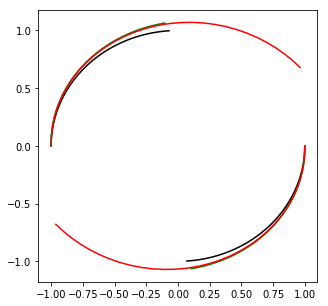

In [48]:
HStep = 0.1

euler_solver = EulerSolver(dyn=gravity, h=HStep)
rk_solver = RungeKutte(dyn=gravity, h=HStep)
nn_solver = NNSolver(dyn=gravity, h=HStep)
#nn_solver.xs = nn.Parameter(torch.tensor([0.5, 0.5, 1], dtype=TType))
#nn_solver.ws = nn.Parameter(torch.tensor([1/6, 1/3, 1/3, 1/6], dtype=TType))



T = run_dynamics(State0, {'euler' : euler_solver, 'rk' : rk_solver, 'nn' : nn_solver}, 30, detach=True)
loss0 = eval_loss(T['rk'], T['nn'])
print("loss: {}".format(loss0))
plt.figure(figsize=(5,5))
plot_h(T['rk'], 'black')
plot_h(T['euler'], 'g')
plot_h(T['nn'], 'r')

## Рунге-Кутта учит NN

In [49]:
optimizer = optim.Adam(nn_solver.parameters(), lr=0.001)

loss: 1.1791260021709604e-06
loss: 4.3022939166803553e-07
loss: 7.219730377983069e-07
loss: 6.350741159621975e-07
loss: 2.954056697035412e-07
loss: 4.990213824385137e-07
loss: 3.127315437723155e-07
loss: 2.209565792554713e-07
loss: 3.1679621770308586e-07
loss: 1.8212975305686996e-07
loss: 1.9598209632931685e-07
loss: 2.2504103469600523e-07
loss: 1.5655949425763538e-07
loss: 1.9205283763312764e-07
loss: 1.8805612000960537e-07
loss: 1.6124411672535643e-07
loss: 1.8618936792336171e-07
loss: 1.7106309257997054e-07
loss: 1.6418249515481875e-07
loss: 1.7476301650276582e-07
loss: 1.6085975573787437e-07
loss: 1.6183803097646887e-07
loss: 1.636201716337382e-07
loss: 1.557995261691758e-07
loss: 1.585808462323257e-07
loss: 1.5702183020493976e-07
loss: 1.5413824883125926e-07
loss: 1.5642515904801257e-07
loss: 1.5449128909494902e-07
loss: 1.5424991772761132e-07
loss: 1.552492108203296e-07
loss: 1.5387624330287508e-07
loss: 1.544167673728225e-07
loss: 1.5436013711678243e-07
loss: 1.5386909524295334e

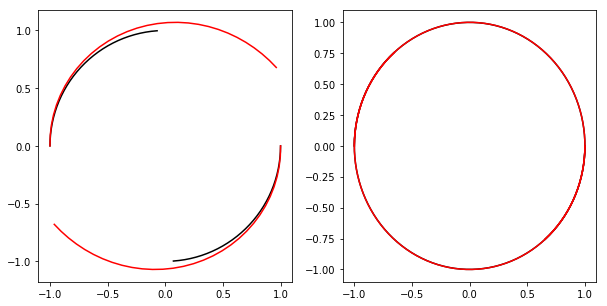

In [53]:
TSize = 80

for epoch in range(200):
    optimizer.zero_grad()
    
    T_l = run_dynamics(State0, {'rk' : rk_solver, 'nn' : nn_solver}, steps=TSize)
    loss = eval_loss(T_l['rk'], T_l['nn'])
    
    if epoch % 2 == 0:
        print("loss: {}".format(loss))

    nn_solver.zero_grad()
    loss.backward()
    optimizer.step()

print("loss0: {}, loss: {}".format(loss0, loss))
T_e = run_dynamics(State0, {'euler' : euler_solver, 'rk' : rk_solver}, TSize, detach=True)
print("e_loss: {}".format(eval_loss(T_e['rk'], T_e['euler'])))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_h(T['rk'], 'black')
plot_h(T['nn'], 'r')

plt.subplot(1,2,2)
plot_h(T_l['rk'], 'black')
plot_h(T_l['nn'], 'r')

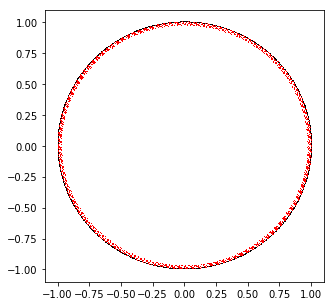

In [54]:
T_c = run_dynamics(State0, {'rk' : rk_solver, 'nn' : nn_solver}, steps=1000, h=0.1, detach=True)

plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

In [56]:
nn_solver.ws

Parameter containing:
tensor([-0.1084,  0.4505,  0.4322,  0.2264], requires_grad=True)

## Учимся по законам сохранения

In [220]:
def eval_energy_loss(dynamics):
    es = [energy(d) for d in dynamics]
    t = torch.stack(es)
    return ((t[1:] - t[:-1])**2).mean()

loss: 0.023146215826272964


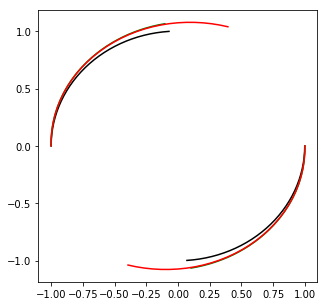

In [229]:
HStep = 0.1

euler_solver = EulerSolver(dyn=gravity, h=HStep)
rk_solver = RungeKutte(dyn=gravity, h=HStep)
nn_solver = NNSolver(dyn=gravity, h=HStep)
#nn_solver.xs = nn.Parameter(torch.tensor([0.5, 0.5, 1], dtype=TType))
#nn_solver.ws = nn.Parameter(torch.tensor([1/6, 1/3, 1/3, 1/6], dtype=TType))



T = run_dynamics(State0, {'euler' : euler_solver, 'rk' : rk_solver, 'nn' : nn_solver}, 30, detach=True)
loss0 = eval_loss(T['rk'], T['nn'])
print("loss: {}".format(loss0))
plt.figure(figsize=(5,5))
plot_h(T['rk'], 'black')
plot_h(T['euler'], 'g')
plot_h(T['nn'], 'r')

In [230]:
optimizer = optim.Adam(nn_solver.parameters(), lr=0.002)

In [232]:
TSize = 100

for epoch in range(2000):
    optimizer.zero_grad()
    
    NN_D = run_dynamics(State0, {'nn' : nn_solver}, steps=TSize)
    loss = eval_energy_loss(NN_D['nn'])
    
    if epoch % 2 == 0:
        print("loss: {}".format(loss))

    nn_solver.zero_grad()
    loss.backward()
    optimizer.step()

loss: 3.4009747906793564e-08
loss: 3.105039425577161e-08
loss: 2.8297501231122624e-08
loss: 2.574302548907781e-08
loss: 2.3372676238864187e-08
loss: 2.117999819972738e-08
loss: 1.9154926533815342e-08
loss: 1.7286748033029653e-08
loss: 1.55688031355794e-08
loss: 1.3989640557099392e-08
loss: 1.2543575067525126e-08
loss: 1.1220801177103112e-08
loss: 1.0013589957225122e-08
loss: 8.91442830663891e-09
loss: 7.916196587132163e-09
loss: 7.0114789529895916e-09
loss: 6.193971113788166e-09
loss: 5.456921137181325e-09
loss: 4.794733943214169e-09
loss: 4.200872538717704e-09
loss: 3.6699117078597965e-09
loss: 3.1963560687131576e-09
loss: 2.7759481380229545e-09
loss: 2.403114596205569e-09
loss: 2.0737698225303802e-09
loss: 1.784005831950708e-09
loss: 1.5294915334251868e-09
loss: 1.3067394943888644e-09
loss: 1.1125907972697746e-09
loss: 9.440084269840554e-10
loss: 7.979001348523695e-10
loss: 6.719287903855786e-10
loss: 5.636176525491976e-10
loss: 4.709969636529365e-10
loss: 3.919702895593957e-10
loss:

KeyboardInterrupt: 

In [245]:
GravitySystem = Gravity(torch.tensor([1, 1, 1], dtype=TType))
gravity = GravitySystem['dyn']
energy = GravitySystem['energy']

XPos = torch.tensor([[-1, 0], 
                      [1, 0],
                      [0, 1]], dtype=TType)


Vels = torch.tensor([[0,  0.2],
                     [0, -0.2],
                     [0.2,  0]], dtype=TType)

State0 = torch.stack([XPos, Vels])

In [251]:
rk_solver = RungeKutte(gravity)
nn_solver.dyn = gravity

In [262]:
T_c = run_dynamics(State0, {'rk' : rk_solver, 'nn' : nn_solver}, steps=2000, h=0.001, detach=True)

loss_rk: 33.079750061035156, loss: 0.0009812647476792336, d_loss: 3.6715939044952393


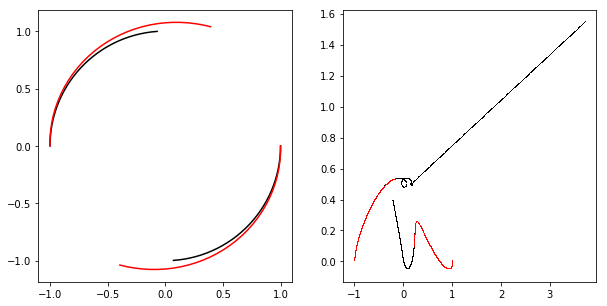

In [263]:
e_loss = eval_energy_loss(T_c['nn'])
e_loss_rk = eval_energy_loss(T_c['rk'])

d_loss = eval_loss(T_c['rk'], T_c['nn'])

print("loss_rk: {}, loss: {}, d_loss: {}".format(e_loss_rk, e_loss, d_loss))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_h(T['rk'], 'black')
plot_h(T['nn'], 'r')

plt.subplot(1,2,2)
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

In [239]:
nn_solver.ws

Parameter containing:
tensor([ 0.3803,  0.0718, -0.0814,  0.2960], requires_grad=True)

In [240]:
nn_solver.xs

Parameter containing:
tensor([0.1671, 0.2545, 0.7804], requires_grad=True)

In [280]:
energy(T_c['nn'][400])

tensor(-0.2592)

In [237]:
2*torch.rand(4) - 1

tensor([-0.7262,  0.1119,  0.9504,  0.2622])

In [254]:
HStep = 0.1
eps = 1e-1
NSteps = 1000
euler_solver = EulerSolver(dyn=gravity, h=HStep)
rk_solver = RungeKutte(dyn=gravity, h=HStep)
RK_D = run_dynamics(State0, {'rk' : rk_solver}, NSteps, detach=True)

losses = []
t0 = time()
for i in range(10):
    print("Shoot: {}".format(i))
    nn_solver = NNSolver(dyn=gravity, h=HStep)
    
    xs = torch.tensor([0.5, 0.5, 1], dtype=TType) + eps*(2*torch.rand(3) - 1)
    ys = torch.tensor([1/6, 1/3, 1/3, 1/6], dtype=TType) + eps*(2*torch.rand(4) - 1)
    nn_solver.xs = nn.Parameter(xs)
    nn_solver.ws = nn.Parameter(ys)

    NN_D = run_dynamics(State0, {'nn' : nn_solver}, NSteps, detach=True)
    losses.append(eval_loss(RK_D['rk'], NN_D['nn']))
    
print(time() - t0)

Shoot: 0
Shoot: 1
Shoot: 2
Shoot: 3
Shoot: 4
Shoot: 5
Shoot: 6
Shoot: 7
Shoot: 8
Shoot: 9
12.792181491851807


In [252]:
losses

[tensor(0.4993),
 tensor(4478.8745),
 tensor(0.5930),
 tensor(0.3069),
 tensor(0.1609),
 tensor(0.1318),
 tensor(809.4890),
 tensor(0.6472),
 tensor(0.7225),
 tensor(0.5124)]

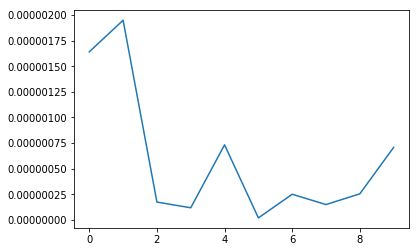

In [245]:
plt.plot(losses)

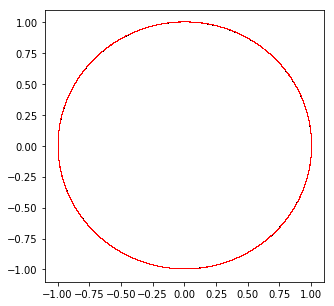

In [248]:
plt.figure(figsize=(5,5))
plot_h(RK_D['rk'], ',', color='black')
plot_h(NN_D['nn'], ',', color='r')

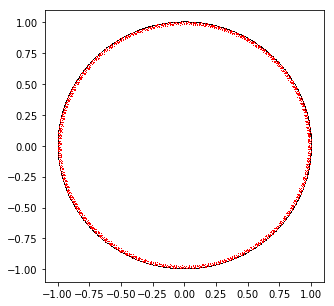

In [191]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

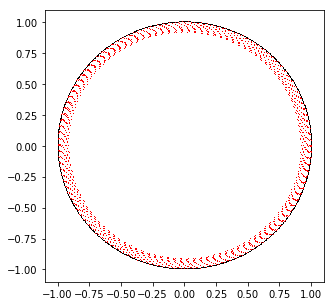

In [188]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

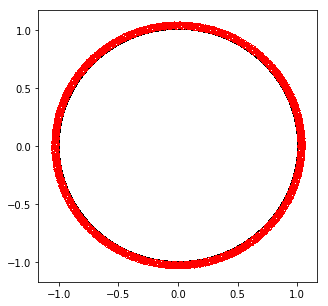

In [152]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

In [180]:
nn_solver.ws

Parameter containing:
tensor([ 0.3375,  0.5436, -0.0780,  0.1968], requires_grad=True)

In [181]:
nn_solver.xs

Parameter containing:
tensor([ 0.6486, -0.3332,  0.6565], requires_grad=True)

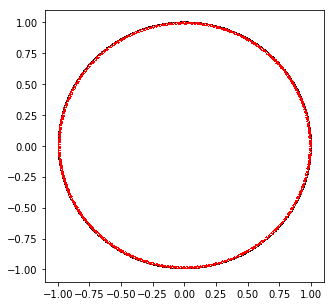

In [96]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

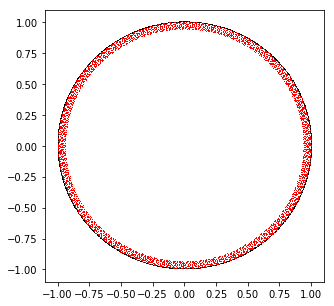

In [93]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

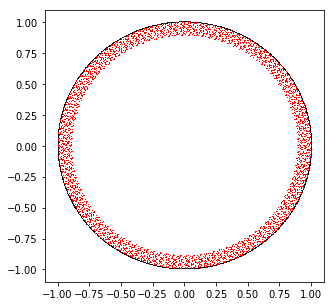

In [90]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

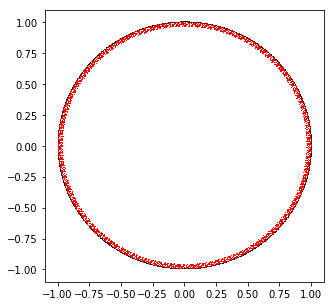

In [87]:
plt.figure(figsize=(5,5))
plot_h(T_c['rk'], ',', color='black')
plot_h(T_c['nn'], ',', color='r')

In [82]:
nn_solver.xs

Parameter containing:
tensor([0.5845, 0.4266, 0.2496], requires_grad=True)

In [83]:
nn_solver.ws

Parameter containing:
tensor([-0.0401,  0.7768, -0.0975,  0.3615], requires_grad=True)

In [49]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

loss: 34130.19921875


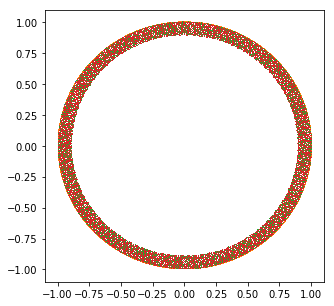

In [600]:
k_states_t, nn_states_t, loss = run_dynamics(10000)

print("loss: {}".format(loss))
plt.figure(figsize=(5,5))
plot_h(k_states_t, ',')
plot_h(nn_states_t, ',')


In [602]:
nn_solver.xs

Parameter containing:
tensor([0.1488, 0.4642, 0.9074], requires_grad=True)

In [603]:
nn_solver.ws

Parameter containing:
tensor([ 0.2591, -0.1598,  0.6602,  0.2406], requires_grad=True)

In [587]:
nn_solver.xs

Parameter containing:
tensor([0.1471, 0.4638, 0.9076], requires_grad=True)

In [588]:
nn_solver.ws

Parameter containing:
tensor([ 0.2591, -0.1598,  0.6602,  0.2406], requires_grad=True)

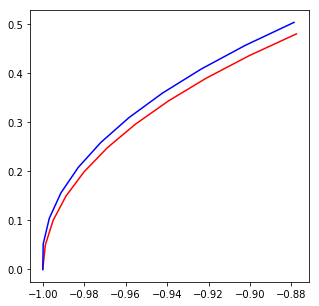

In [378]:
plt.figure(figsize=(5,5))
plot_h(k_states, 'r')
plot_h(nn_states, 'b')